In [1]:
import numpy
import cv2

In [2]:
import random

In [3]:
import matplotlib.pyplot as plt

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

In [5]:
import torch
from torch import nn

In [6]:
from fastai.vision.all import *

In [7]:
class custom_dataset(Dataset):
    def __init__(self,n):
        self.n = n
        pass
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        img = numpy.zeros((300,300,3))
        nc_rgb = {0:0,1:0,2:0}
        for nc in range(random.randint(5,14)):
            cx = random.randint(30,270)
            cy = random.randint(30,270)
            center_coordinates = (cx, cy)
            radius = random.randint(5,20)
            # color in RGB
            color = [0,0,0]
            color_idx = random.randint(0,2)
            color[color_idx] = 1
            nc_rgb[color_idx] += 1
            thickness = -1
            image = cv2.circle(img, center_coordinates, radius, color, thickness)
        k =  random.randint(0,2)
        image = torch.Tensor(image).permute(2,1,0)
        img_1 = torch.zeros((1, 300,300))
        img_1[:] = k
        return (torch.cat([img_1, image]), torch.tensor(nc_rgb[k],dtype=torch.float32))

In [8]:
batch_size = 128

In [9]:
train_dataloader = DataLoader(custom_dataset(8196), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(custom_dataset(1024), batch_size=batch_size, shuffle=True)

In [10]:
class custom_model(nn.Module):
    def __init__(self):
        super(custom_model, self).__init__()
        self.conv_layers = nn.Sequential(
        nn.Conv2d(4, 8, 3),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 16, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, 3, stride=2),
        nn.ReLU(),
        )
        self.linear = nn.Linear(9248,1,bias=True)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0],-1)
        x = self.linear(x).squeeze(1)
        return x

### Fastai learner class 

In [11]:
data = DataLoaders(train_dataloader, test_dataloader, device='cuda')

In [12]:
learn = Learner(data, custom_model(), loss_func=F.mse_loss, opt_func=Adam)

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0002290867705596611)

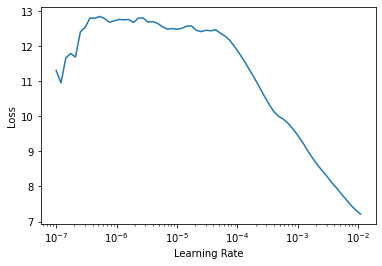

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,3.791472,3.421913,00:28
1,1.863721,1.191887,00:29
2,1.262247,1.137407,00:28
3,1.056918,0.739526,00:28
4,0.748010,0.741453,00:28
5,0.590285,0.417444,00:28
6,0.520076,0.444379,00:28
7,0.448227,0.394300,00:28
8,0.413128,0.306632,00:28
9,0.353999,0.338031,00:28


In [26]:
learn.save('nn_metadata_appoach_2_8k.pth')

Path('models/nn_metadata_appoach_2_8k.pth.pth')

In [27]:
test_features, test_labels = next(iter(test_dataloader))

In [28]:
x, y = next(iter(test_dataloader))
im = x[71]

In [29]:
img_1 = im[0,:,:]

In [30]:
im = im[1:,:,:]

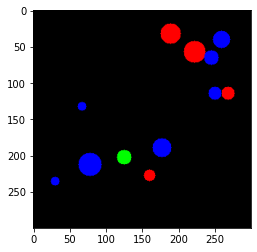

In [31]:
plt.imshow(im.cpu().permute(2,1,0))

In [32]:
#Red
img_1[:] = 0
print(learn.model(torch.cat([img_1.unsqueeze(0), im]).unsqueeze(0)).item())

4.155447006225586


In [33]:
#Green
img_1[:] = 1
print(learn.model(torch.cat([img_1.unsqueeze(0), im]).unsqueeze(0)).item())

1.3724888563156128


In [34]:
#Blue
img_1[:] = 2
print(learn.model(torch.cat([img_1.unsqueeze(0), im]).unsqueeze(0)).item())

6.411185264587402


In [35]:
def test_by_changing_metadata():
    figure = plt.figure(figsize=(11, 11))
    cols, rows = 3,5
    col_dict = {0:'red',1:'green',2:'blue'}
    x,y = next(iter(train_dataloader))
    counter=1
    for i in range(1, rows + 1):
        im = x[random.randint(0,127)]
        img_1 = im[0,:,:]
        im = im[1:,:,:]
        for j in range(1,cols+1):
            img_1[:] = j - 1
            pred = learn.model(torch.cat([img_1.unsqueeze(0), im]).unsqueeze(0)).item()
            figure.add_subplot(rows, cols, counter)
            counter+=1
            plt.title(f"{pred:.2f}, {col_dict[j-1]}")
            plt.axis("off")
            plt.imshow(im.cpu().permute(2,1,0))
    plt.show()

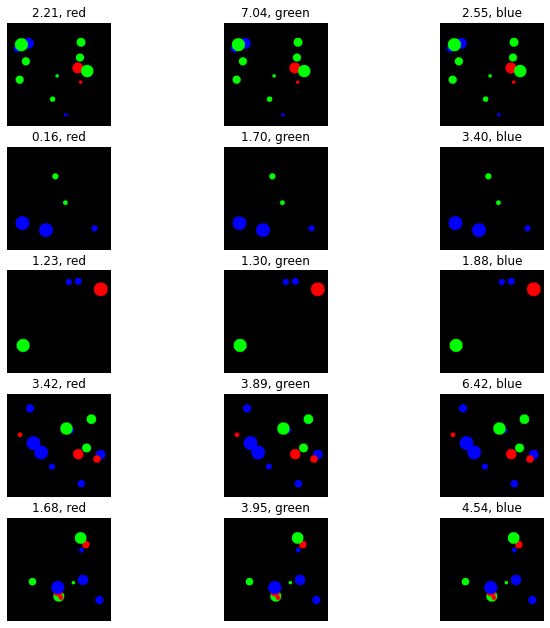

In [36]:
test_by_changing_metadata()